<div align="center" style="border:solid 1px gray;">
    <a href="https://openalex.org/">
        <img src="https://raw.githubusercontent.com/ourresearch/openalex-api-tutorials/1988d22c5499d6a1f68d85ef2902b600b555aaa5/resources/img/OpenAlex-banner.png" alt="OpenAlex banner" width="300">
    </a>
</div>

# Monitoring Open Access publications for a given institution

<div style='background:#e7edf7'>
    In this notebook we will query the OpenAlex API to answer the question:
    <blockquote>
        <b><i>How many of recent journal articles from a given institution are Open Access? And how many aren't?</i></b>
    </blockquote>
    To get to the bottom of this, we will use the following API functionalities: 
    <a href="https://docs.openalex.org/how-to-use-the-api/get-lists-of-entities/filter-entity-lists">filtering</a> and 
    <a href="https://docs.openalex.org/how-to-use-the-api/get-groups-of-entities">grouping</a>
</div>
<br>

Imagine you would like to track the University of Florida's progress in the transition towards Open Access (OA). How could you do that using OpenAlex?

### Steps
Let's start by dividing the process into smaller, more manageable steps:
1. First we need to get all recent journal articles from the University of Florida
2. Next we divide them into open and closed access
3. Finally we count the publications in each category
4. Additionally we can put the numbers into a plot to visualize our findings

### Input
The only input we need is an identifier for the institution and here we opted for its [ROR ID](https://ror.org/).  
If we look up the University of Florida in the ROR registry we find its ROR ID is https://ror.org/02y3ad647:

In [ ]:
#input
# ror = 'https://ror.org/02y3ad647'
ror = 'https://ror.org/00p4k0j84' #九州大学

All set, so let's dive in!

<hr>

## 1. Get all recent journal articles from the University of Florida
The first step in querying OpenAlex is always to build the URL to get exactly the data we need. We need to ask two things:
1. About which entity type (author, concept, institution, venue, work) do we want data?  
* --> Since we want to query for metadata about "_journal articles_", the entity type should be `works`.

2. What are the criteria the works need to fulfill to fit our purpose?  
* Here we need to look into the list of available [filters for works](https://docs.openalex.org/api-entities/works/filter-works) and select the appropriate ones.  
* --> We want to query for "_all recent journal articles from the University of Florida_", so we will filter for the works that:
  * were published in the last 10 years (=recent): `from_publication_date:2012-08-24`,
  * are specified as articles: `type:article`,
  * have at least one [authorship](https://docs.openalex.org/api-entities/works/work-object#authorships) affiliation with the University of Florida: `institutions.ror:https://ror.org/02y3ad647`,
  * are not [paratext](https://docs.openalex.org/api-entities/works/work-object#is_paratext): `is_paratext:false`

<br>

Now we need to **put the URL together** from these parts as follows:  
* Starting point is the base URL of the OpenAlex API: `https://api.openalex.org/`
* We append the entity type to it: `https://api.openalex.org/works`
* All criteria need to go into the query parameter `filter` that is added after a question mark: `https://api.openalex.org/works?filter=`
* To construct the filter value we take the criteria we specified and concatenate them using commas as separators:  
`https://api.openalex.org/works?filter=institutions.ror:https://ror.org/02y3ad647,type:article,from_publication_date:2012-08-24,is_paratext:false`

With this URL we can get all recent journal articles from the University of Florida!

In [ ]:
from_date = "2020-01-01"
to_date = "2024-12-31"

## topics.domain
# id:1 Life Sciences
#'id:2, Social Sciences
#'id:3, Physical Sciences
#'id:4, Health Sciences
## topics.field
# id:11, Agricultural and Biological Sciences (農学・生物科学)
# id:12, Arts and Humanities (人文科学)
# id:13, Biochemistry, Genetics and Molecular Biology (生化学・遺伝学・分子生物学)
# id:14, Business, Management and Accounting (経営学・管理学・会計学)
# id:15, Chemical Engineering (化学工学)
# id:16, Chemistry (化学)
# id:17, Computer Science (コンピューターサイエンス)
# id:18, Decision Sciences (意思決定科学)
# id:19, Earth and Planetary Sciences (地球惑星科学)
# id:20, Economics, Econometrics and Finance (経済学・計量経済学・金融学)
# id:21, Energy (エネルギー学)
# id:22, Engineering (工学)
# id:23, Environmental Science (環境科学)
# id:24, Immunology and Microbiology (免疫学・微生物学)
# id:25, Materials Science (材料科学)
# id:26, Mathematics (数学)
# id:27, Medicine (医学)
# id:28, Neuroscience (神経科学)
# id:29, Nursing (看護学)
# id:30, Pharmacology, Toxicology and Pharmaceutics (薬理学、毒性学および製剤学)
# id:31, Physics and Astronomy (物理学および天文学)
# id:32, Psychology (心理学)
# id:33, Social Sciences (社会科学)
# id:34, Veterinary (獣医学)
# id:35, Dentistry (歯学)
# id:36, Health Professions (医療専門職)

def build_institution_works_url(ror):
    # specify endpoint
    endpoint = 'works'

    # build the 'filter' parameter
    filters = (
        f'institutions.ror:{ror}',
        'is_paratext:false',
        'type:article',
        #'topics.domain.id:1', #Life Sciences
        #'topics.field.id:26', #Mathematics(数学)
        #'topics.field.id:27', #Medicine(医学)
        #'topics.field.id:27|28', #Medicine(医学) or Neuroscience(神経科学)
        #'topics.field.id:27|28|29|30|34|35|36', #医学、神経科学、看護学、薬学、獣医学、歯学、医療専門職
        f'from_publication_date:{from_date}',
        f'to_publication_date:{to_date}'
    )

    # put the URL together
    return f'https://api.openalex.org/{endpoint}?filter={",".join(filters)}'

filtered_works_url = build_institution_works_url(ror)
print(f'complete URL with filters:\n{filtered_works_url}')

<hr>

## 2. Divide them into open and closed access
To get the number of open and closed works, we need to find an additional attribute that we can use to divide the retrieved works further into these categories. Fortunately OpenAlex includes information about the access status of a work in its metadata via the nested [OpenAccess object](https://docs.openalex.org/api-entities/works/work-object#the-openaccess-object). It is made up of the three attributes
* `is_oa` _(Boolean): True if this work is Open Access._
* `oa_status` _(String): The Open Access (OA) status of this work. Possible values are gold, green, hybrid, bronze, closed._
* `oa_url` _(String): The best Open Access (OA) URL for this work._

**-->`is_oa` seems to be exactly the criterion we are looking for!**


#### Shortcut `group_by`
So one way to get the number of open and closed works would be to add `is_oa` as an additional filter to our query and query OpenAlex for each value in its range `{true, false}` to get its resulting count of works, e.g.
* `filter=...,is_oa:true`
* `filter=...,is_oa:false`


But wait! Isn't that exactly what `group_by` does?  
Yes, absolutely, the `group_by` parameter takes one attribute as input, divides the list of results based on the attribute's values and returns each of their counts. What a time saver!

Let's add `group_by=is_oa` as an additional query parameter to the end of our URL:

In [ ]:
# group_by_param = 'group_by=is_oa'
# group_by_param = 'group_by=oa_status'
group_by_param = 'group_by=topics.field.id'

work_groups_url = f'{filtered_works_url}&{group_by_param}'
print(f'complete URL with group_by:\n{work_groups_url}')

<hr>

## 3. Count the number of works in each group

After putting together the URL, we can query OpenAlex for the groups of publications and retrieve the following two groups:

In [ ]:
import requests, json
response = requests.get(work_groups_url).json()

work_groups = response['group_by']
print(json.dumps(work_groups, indent=2))

Each group is made up of its `key` that contains the attribute value for the `group_by` attribute, in our case `is_oa`, and its `count` of entities belonging to the group. Given these data we can already answer our initial question:  
> _How many of recent journal articles from a given institution are Open Access? And how many aren't?_

In [ ]:
def calculate_oa_status_percentages(work_groups):
    # 総出版物数を計算
    total_count = sum(group['count'] for group in work_groups)

    # 各OAステータスの割合を表示
    for index, group in enumerate(work_groups):
        oa_status = group['key_display_name']
        count = group['count']
        print(f"--> Group {index+1} includes all works where `oa_status` is {oa_status} and has a count of {count} publications.")

        if total_count > 0:
            percentage = count / total_count
            print(f"That makes a {oa_status} percentage of {percentage:.6f}")
        else:
            print(f"{oa_status} percentage can't be determined, no publications in result")

# 関数の実行
calculate_oa_status_percentages(work_groups)


<hr>

## 4. Plot the data (optional)
Last but not least we can put the data into a visually appealing plot. How about a donut plot?

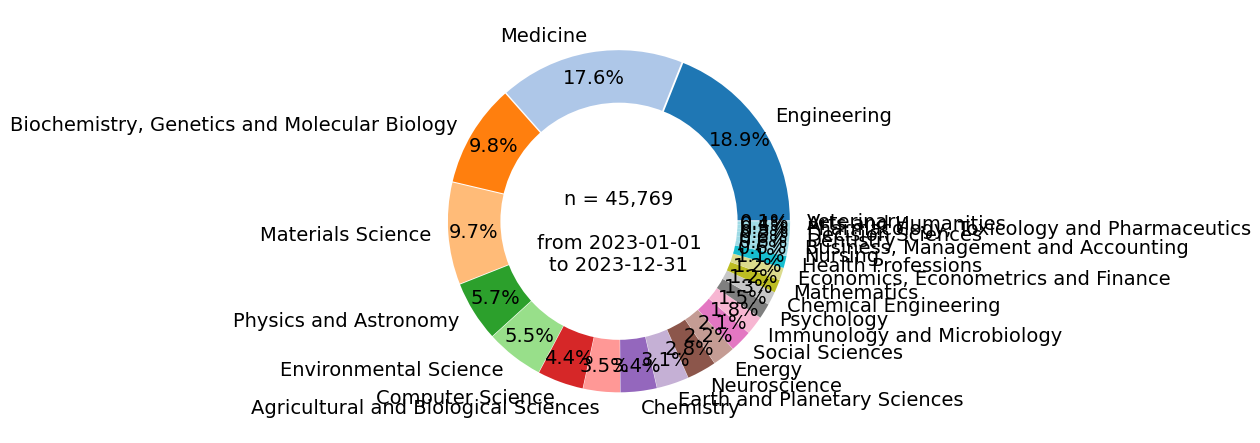

In [23]:
import matplotlib.pyplot as plt

# 円グラフに表示する見出し（分野等）
field_name = ""

# OAステータスの表示順と色（固定値）
fixed_order = ["closed", "gold", "hybrid", "bronze", "green", "diamond"]
fixed_colors = {
    "closed": "#f84f31",
    "gold": "#f4c542",
    "bronze": "#cd7f32",
    "hybrid": "#6a5acd",
    "green": "#23c552",
    "diamond": "#00ced1"
}

# ラベル、値、色を構築
labels = []
counts = []
colors = {}

if group_by_param == "group_by=oa_status":
    labels = fixed_order
    colors = fixed_colors
    for label in labels:
        count = next((group["count"] for group in work_groups if group["key_display_name"] == label), 0)
        counts.append(count)
else:
    labels = [group["key_display_name"] for group in work_groups]
    counts = [group["count"] for group in work_groups]
    # 動的に色を割り当て（カラーマップを使用）
    cmap = plt.get_cmap("tab20")
    colors = {label: cmap(i) for i, label in enumerate(labels)}

# 総出版物数
total_count = sum(counts)

# ドーナツ型円グラフの作成
def create_donut_plot(labels, counts, total_count, field_name, from_date, to_date):
    # plt.rcParams["figure.figsize"] = (8, 5.5) #幅, 高さ
    plt.rcParams["figure.figsize"] = (8, 5.5) #幅, 高さをここで調整
    explode = [0.01] * len(labels)
    color_list = [colors[label] for label in labels]

    # 円グラフ
    plt.pie(counts, labels=labels, colors=color_list,
            autopct='%1.1f%%', pctdistance=0.85,
            explode=explode, textprops={'fontsize': 14})

    # 中央の白円
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # 中央にフィルター情報と総数を表示（コンマ区切り）
    center_text = f"{field_name}\nn = {total_count:,}\n\nfrom {from_date}\nto {to_date}"
    plt.text(0, 0, center_text, ha='center', va='center', fontsize=14)

    # 表示
    plt.show()

# グラフの描画
create_donut_plot(labels, counts, total_count, field_name, from_date, to_date)

---
Feel free to use the notebook and determine the percentage of Open Access works for your institution or tweak the filters to fit your analysis.  

Happy exploring! 😎